# Superancillary iterations

The state of a two-phase point for a pure fluid can be fully specified by the temperature and vapor quality.

When temperature $T$ is known, the vapor quality $q$ can be calculated as
$$
q = \frac{y-y_{\rm ch}'(T)}{y_{\rm ch}''(T)-y_{\rm ch}'(T)}
$$
where $y$ is a property of interest, one of $\lbrace h,s,u\rbrace$. In the case of density, one uses $v=1/\rho$. If $0\leq q \leq 1$ the state point is considered to be single-phase.

For a pure fluid there is no distinction between quality on a mass or molar basis because the molar mass of both phases are identical.

If $p$ is given, one obtains $T(p)$ and uses the calculated $T$ to get the quality.

When neither $T$ nor $p$ are given, one must work harder to determine the temperature and quality. That is the subject of this section.

The residual function to be driven to zero can be implemented as something like:
```
double resid(double T){
 double q_fromv1 = get_vaporquality(T, val1, ch1);
 return get_yval(T, q_fromv1, ch2) - val2;
};
```
One calculates the vapor quality with one of the imposed variables, calculates the other variable's value, and the residual to be driven to zero is then the difference between the given and calculated values of the second variable.

What appears on its face to be a simple residual function is complicated in practice. The complication occurs because one must either
1. Get a good guess value for the temperature to launch the iteration from and do some sort of unbounded Newton solver from this temperature
2. Develop reliable bounds on the temperature that bounds the solution (if such a solution exists).

A solution exists if you can find a $T,q$ pair that gives the specified values of both variables. The solution should be unique in most cases, $h,u$ being an exception.

In [1]:
import json 
import functools
import tarfile

import numpy as np
import matplotlib.pyplot as plt

import teqpflsh 
import CoolProp.CoolProp as CP

In [2]:
FLD = 'PENTANE'
# Extract the JSON from the archive in LZMA compressed format, name is the REFPROP standard name
with tarfile.open('superancillaryJSON.tar.xz', mode='r:xz') as tar:
    # for member in tar.getmembers(): print(member)
    j = json.load(tar.extractfile(f'./{FLD}_exps.json'))

In [3]:
sa = teqpflsh.SuperAncillary(json.dumps(j))

AS = CP.AbstractState('HEOS',FLD)
def calc(T, rho, AS, key):
    AS.specify_phase(CP.iphase_gas)
    AS.update(CP.DmolarT_INPUTS, rho, T)
    val = AS.keyed_output(key)
    AS.unspecify_phase()
    return val

# Order of ms per variable, likely MUCH faster in C++
sa.add_variable(k='S', caller=functools.partial(calc, AS=AS, key=CP.iSmolar))
sa.add_variable(k='H', caller=functools.partial(calc, AS=AS, key=CP.iHmolar))

def plot_base(ax):
    def plot_sat(q):
        approx1dh = sa.get_approx1d(k='H', q=q)
        approx1ds = sa.get_approx1d(k='S', q=q)
    
        Ts = np.linspace(approx1dh.xmin, approx1dh.xmax, 10000)
        S = np.zeros_like(Ts)
        sa.eval_sat_many(k='S', T=Ts, q=q, y=S)
        H = np.zeros_like(Ts)
        sa.eval_sat_many(k='H', T=Ts, q=q, y=H)
    
        ax.plot(S, H, color='k')
        return S[0], H[0]
    
    s0, h0 = plot_sat(q=0)
    s1, h1 = plot_sat(q=1)
    ax.plot([s0,s1], [h0,h1], dashes=[3,1,1,1], color='k')
        
    ax.set(xlabel='$s$ / J/mol/K', ylabel='$h$ / J/mol')

Tc = sa.get_approx1d(k='S', q=1).xmax

The problems begin with entropy as an input. Let's suppose that we consider the following $h,s$ coordinates for $n$-pentane. Along the saturated vapor curve, there are three intersections at the given value of entropy

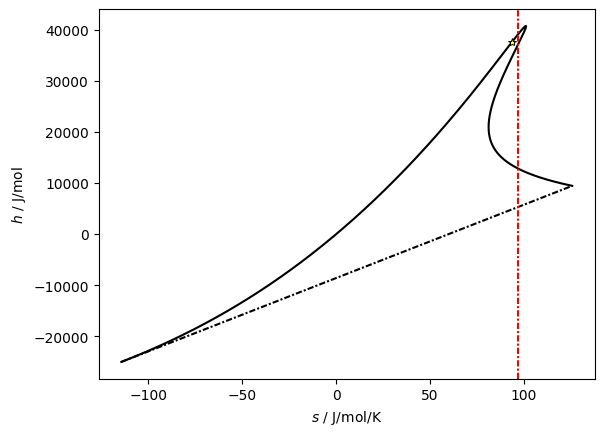

In [4]:
fig, ax = plt.subplots(1,1)
plot_base(ax)
hc = sa.get_approx1d(k='H', q=1).eval(Tc)
sc = sa.get_approx1d(k='S', q=1).eval(Tc)
plt.plot(sc, hc, '*', color='yellow', mew=0.7, mec='k')
ax.axvline(97, color='red', dashes=[3,1,1,1]);

label (h,s coordinates)
A [-5.743214751940169, -2941.112588584603]
B [96.72730245435365, 37648.0894811022]
C [96.72730245435365, 17648.0894811022]


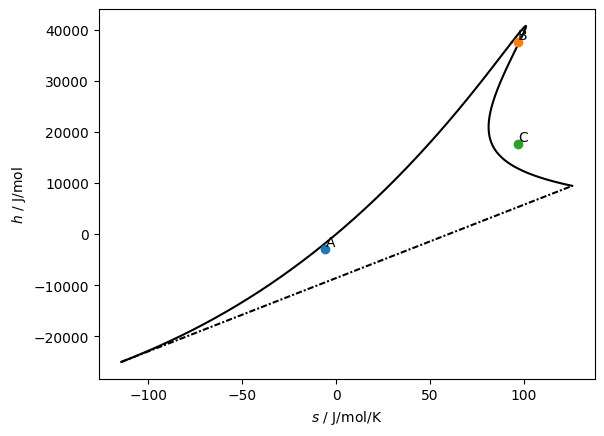

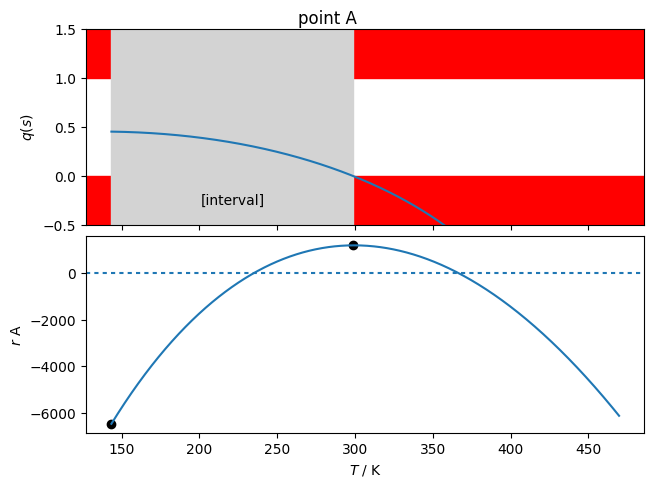

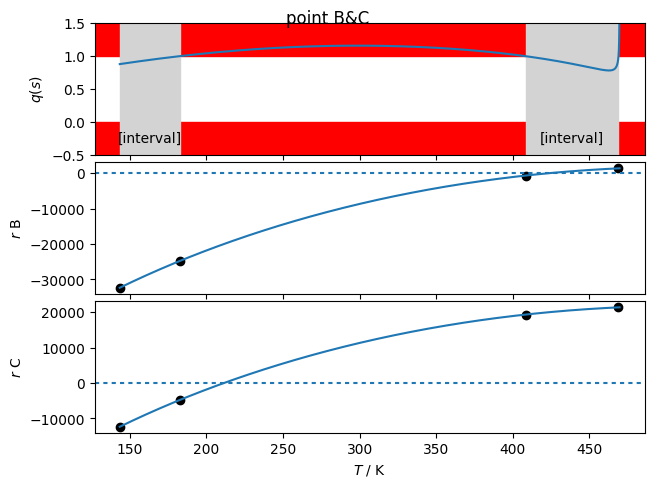

In [5]:
Tpt = 235; q = 0.3
hptA = sa.get_yval(k='H', T=Tpt, q=q)
sptA = sa.get_yval(k='S', T=Tpt, q=q)

Tpt = 0.9*Tc; q = 0.95
hptB = sa.get_yval(k='H', T=Tpt, q=q)
sptB = sa.get_yval(k='S', T=Tpt, q=q)

hptC = hptB-20000
sptC = sptB

def overlay_points(points, ofname, *, suptitle=None, ylabels=None):

    figg, axes = plt.subplots(1+len(points), 1, sharex=True)

    approx1dh = sa.get_approx1d(k='H', q=0)
    approx1ds = sa.get_approx1d(k='S', q=0)
    Ts = (np.geomspace(approx1dh.xmin, 0.9*approx1dh.xmax, 1000).tolist() 
    + np.geomspace(0.9*approx1dh.xmax, approx1dh.xmax*0.999999, 100000).tolist())

    for ipt, (hpt, spt) in enumerate(points):

        axmain.plot(spt, hpt, 'o')

        r, Qcalc = [], []
        for T in Ts:
            qq = sa.get_vaporquality(T=T, k='S', propval=spt)
            qh = sa.get_vaporquality(T=T, k='H', propval=hpt)
            r.append(sa.get_yval(T=T, q=qq, k='H')-hpt)
            Qcalc.append(qq)

        solns = (
            sa.solve_for_T(propval=spt, k='S', q=True, bits=64, max_iter=100, boundsftol=1e-13)
            + sa.solve_for_T(propval=spt, k='S', q=False, bits=64, max_iter=100, boundsftol=1e-13)
        )
        if len(solns) == 3:
            bands = [(approx1dh.xmin, solns[0][0]),(solns[1][0], solns[2][0])]
        elif len(solns) == 2:
            bands = [(solns[0][0], solns[1][0])]
        elif len(solns) == 1:
            bands = [(approx1dh.xmin, solns[0][0])]
        else:
            raise ValueError(len(solns))

        if ipt == 0:
            ax1 = axes[0]
            ax1.plot(Ts, np.array(Qcalc))
            ax1.set_ylim(-0.5,1.5)
            ax1.set(ylabel=r'$q(s)$')
            ax1.axhspan(1,1.5, color='red', zorder=-1)
            ax1.axhspan(-0.5, 0, color='red', zorder=-1)
            for band in bands:
                ax1.axvspan(*band, color='lightgrey')
                ax1.text(np.mean(band), -0.25, '[interval]',ha='center', va='center')

        for band in bands:
            for T in band:
                qq = sa.get_vaporquality(T=T, k='S', propval=spt)
                qh = sa.get_vaporquality(T=T, k='H', propval=hpt)
                rr = sa.get_yval(T=T, q=qq, k='H')-hpt
                axes[ipt+1].plot(T, rr, 'ko')

        axx = axes[ipt+1]
        axx.plot(Ts, r)
        axx.axhline(0, dashes=[2, 2])
        axx.set_ylabel('$r$' + (f' {ylabels[ipt]}' if ylabels else ''))
        if ipt == len(points)-1:
            axx.set_xlabel('$T$ / K')
        if suptitle:
            figg.suptitle(suptitle)
    figg.tight_layout(pad=0.2)
    # figg.savefig(ofname)

figmain, axmain = plt.subplots(1)
plot_base(axmain)
points = [(hptA, sptA), (hptB, sptB), (hptC, sptC)]
overlay_points(points[0:1], ofname='liquid_side.pdf', suptitle = 'point A', ylabels=['A'])
overlay_points(points[1::], ofname='vapor_side.pdf', suptitle = 'point B&C', ylabels=['B','C'])
print('label (h,s coordinates)')
for point, label in zip(points, ['A','B','C']):
    print(label, list(reversed(point)))
    axmain.text(*reversed(point), label, ha='left', va='bottom')
# figmain.savefig(f'{FLD}_HS_main.pdf')

We have three points: A, B, and C.

Point A is on the liquid side. When searching for values of entropy yielding $q=0$ or $q=1$ (breakpoints in the possible solution interval), only one solution is found. According to the intermediate value theorem, we know that the interval from $T_{\rm min}$ to the saturated liquid entropy contains one solution because the value of the residual function changes sign in this interval. Thus a bounded solver based on this solution interval can be practically guaranteed to converge. The superancillary routines are used to evaluate the residual function.

Point B and C are on on the vapor side at the same value of entropy. Along the given value of entropy, there are three values of saturated vapor entropy corresponding to the given value of entropy. Thus there are two possible search intervals. In each search interval, if the value of the residual function has the same sign on both edges, the solution can be guaranteed to not exist and the state point must be single-phase. Such is the case for point C. There are two candidate intervals, and in each interval the sign of the residual function is either both positive or both negative at the edges of the intervals. For point B, in one interval the residual function changes sign, and thus, a solution can be found using a bounded solver.

The TOMS748 algorithm is used within teqpflsh to do all bounded rootfinding of 1D residual functions.